In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Do not show warnings
import warnings
warnings.filterwarnings("ignore")

# Read the csv file
file_name = 'accepted_2007_to_2018Q3.csv'
df=pd.read_csv(file_name,low_memory=False)

In [2]:
# Print dimensions of df
df.shape

(2132287, 151)

In [3]:
# Value count the response variable loan_status
df.loan_status.value_counts()

Fully Paid                                             1011841
Current                                                 822105
Charged Off                                             254777
Late (31-120 days)                                       22852
In Grace Period                                          12458
Late (16-30 days)                                         5442
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     32
Name: loan_status, dtype: int64

In [4]:
#Keep only fully paid and charged off because the rest of them cannot be used to make predictions on the probability of
# a loan to become charged off
df = df.loc[(df.loan_status=='Fully Paid') | (df.loan_status=='Charged Off')]

# Print the ratio of fully paid and charged off to all samples in df
df.loan_status.value_counts(normalize=True)

Fully Paid     0.798853
Charged Off    0.201147
Name: loan_status, dtype: float64

In [5]:
# Replace loan_status column with charged_off column which has 0 and 1 values
df.loc[:,'loan_status']=df.loc[:,'loan_status'].map({'Fully Paid':0,'Charged Off':1})

# Rename 'loan_status' to 'charged_off'
df.rename(columns={'loan_status':'charged_off'},inplace=True)

In [6]:
# Print dimensions of df after removing the useless samples.
df.shape

(1266618, 151)

### About 80% of the loans in the dataframe are fully paid. Charged off loans are about 20% of the loans.

In [7]:
# Change issue date to datetime format
df.issue_d = pd.to_datetime(df.issue_d)

# Sort dataframe by issue date
df=df.sort_values(by=['issue_d'])

# Reset index of the dataframe
df.reset_index(drop=True,inplace=True)

In [8]:
# Check datatype of id
df.id.dtype

dtype('O')

In [9]:
# id's datatype is categorical. Check if id's are numbers. If all id's are numbers, the following command will not make 
# any errors
pd.to_numeric(df.id)[:3]

0    87023
1    98339
2    92507
Name: id, dtype: int64

In [10]:
# id is unique in each row. Check if there is any duplicate rows by checking if there is any duplicate ids
df.id.value_counts().head(3)

92015086    1
98183765    1
40380726    1
Name: id, dtype: int64

In [11]:
# Value count url
df.url.value_counts().head(3)

https://lendingclub.com/browse/loanDetail.action?loan_id=77553357    1
https://lendingclub.com/browse/loanDetail.action?loan_id=60617265    1
https://lendingclub.com/browse/loanDetail.action?loan_id=15691424    1
Name: url, dtype: int64

In [12]:
# Remove id and url from df since they have unique value for each sample and will not be useful in the process of model building 
df.drop(['id','url'],axis=1,inplace=True)

#### Features such as collection recovery fee, last payment amount, and features related to hardship and settlement which change or may change during the loan repayment period are removed because they cannot help Lending Club make predictions on the ability of the applicant to pay back the loan at the time the application is received. Therefore, only features such as credit score which are available to Lending Club at the time of processing an application are kept. Interest rate is also kept because it remains fixed during the loan payment, although it is only available once the application is approved.

#### There are many features in the DataFrame such as number of installment accounts opened in past 12 months which are not clear if they are referring to the time the table was created or the time the application was approved. The latter scenario is assumed and these features are kept.

In [13]:
# Accoridng to my understanding of features and based on the reasoning above, the following list of features is removed 
removal_list = ['collection_recovery_fee','last_credit_pull_d','last_fico_range_high','last_fico_range_low','last_pymnt_amnt',
               'last_pymnt_d','next_pymnt_d','out_prncp','out_prncp_inv','recoveries','total_pymnt','total_pymnt_inv',
                'total_rec_int','total_rec_late_fee','total_rec_prncp','hardship_flag','hardship_type','hardship_reason',
                'hardship_status','deferral_term','hardship_amount','hardship_start_date','hardship_end_date',
                'payment_plan_start_date','hardship_length','hardship_dpd','hardship_loan_status',
                'orig_projected_additional_accrued_interest','hardship_payoff_balance_amount','hardship_last_payment_amount',
                'debt_settlement_flag','debt_settlement_flag_date','settlement_status','settlement_date','settlement_amount',
                'settlement_percentage','settlement_term']

# Remove features in removal_list from the dataframe
df.drop(removal_list,axis=1,inplace=True)

In [14]:
# Print number of remaining columns
len(df.columns)

112

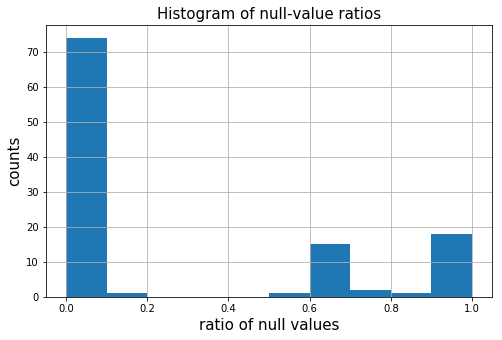

In [15]:
# Calculate the ratio of null values in each column and plot the histogram of the ratios across all columns
plt.figure(figsize=(8,5))
mean_series = df.isnull().mean()
mean_series.plot.hist(grid=True)
plt.title('Histogram of null-value ratios',fontsize=15)
plt.xlabel('ratio of null values',fontsize=15)
plt.ylabel('counts',fontsize=15)
plt.show()

In [16]:
# There are two groups of null-value ratios, below 20% and beyond 50%. Print the second category
np.round(mean_series[mean_series>=0.2].sort_values(),3)

mths_since_last_delinq                 0.505
max_bal_bc                             0.632
inq_fi                                 0.632
open_rv_24m                            0.632
open_rv_12m                            0.632
total_bal_il                           0.632
open_act_il                            0.632
open_il_12m                            0.632
open_il_24m                            0.632
inq_last_12m                           0.632
total_cu_tl                            0.632
open_acc_6m                            0.632
all_util                               0.632
mths_since_rcnt_il                     0.642
mths_since_recent_revol_delinq         0.666
il_util                                0.681
mths_since_last_major_derog            0.738
mths_since_recent_bc_dlq               0.763
mths_since_last_record                 0.830
desc                                   0.903
annual_inc_joint                       0.983
dti_joint                              0.983
verificati

In [17]:
#'desc' is loan description provided by the borrower and a null element means no description was provided. 
# Since 90% is missing it is better to remove it
#'member_id' is missing across all samples and must be removed

# Remove 'desc' and 'member_id' columns
df.drop(['desc','member_id'],axis=1,inplace=True)

#### The remaining features with high null-value ratio can be divided into two groups: features specific to primary and secondary applicants

In [18]:
# Check the ratio of individual and joint applications by investigating 'application_type' column
df.application_type.value_counts(normalize=True)

Individual    0.983418
Joint App     0.016582
Name: application_type, dtype: float64

#### Features specific to the secondary applicant have null values across individual applications because only joint applications have a secondary applicant. Since less than 2% of the loans are joint and the 'application_type' feature indicates if an application is joint or individual, these features are also removed to reduce the complexity of the model building process.

In [19]:
# Create a list of features specific to the secondary applicant
joint_list = ['annual_inc_joint','dti_joint','verification_status_joint','revol_bal_joint','sec_app_fico_range_low',
              'sec_app_fico_range_high','sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc',
              'sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts',
              'sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog']

# Remove features in joint_list from df
df.drop(joint_list,axis=1,inplace=True)

In [20]:
# Create the list of features with high ratio of null values which are specific to the primary applicant
list_non_joint = ['mths_since_last_delinq','max_bal_bc','inq_fi','open_rv_24m','open_rv_12m','total_bal_il','open_act_il',
                  'open_il_12m','open_il_24m','inq_last_12m','total_cu_tl','open_acc_6m','all_util','mths_since_rcnt_il',
                  'mths_since_recent_revol_delinq','il_util','mths_since_last_major_derog','mths_since_recent_bc_dlq',
                  'mths_since_last_record']

In [21]:
# Create a function which shows ratio of null values across years for a feature
def plot_null(feature,df=df):
    """This function plots ratio of null values across years for a feature of df"""
    df_copy = df.copy()
    df_copy['issue_year']=df_copy.issue_d.dt.year
    df_copy['boolean'] = df_copy[feature].isnull()
    figure, ax = plt.subplots(figsize=(10,5))
    df_copy.groupby('issue_year')['boolean'].mean().plot.bar(ax=ax)
    ax.set_ylabel('ratio of null value',fontsize=15)
    ax.xaxis.label.set_size(15)
    plt.title(feature,fontsize=20)
    plt.show()

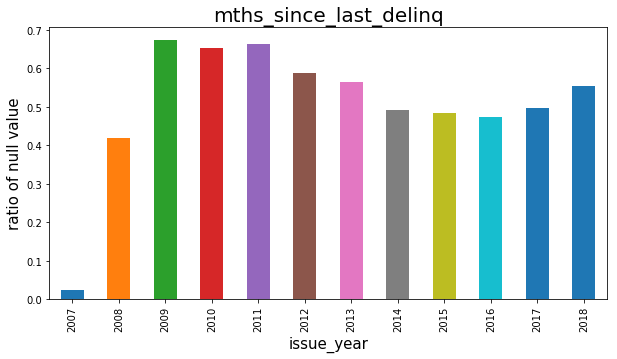

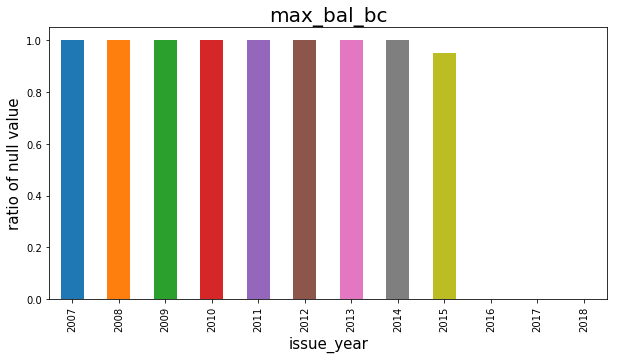

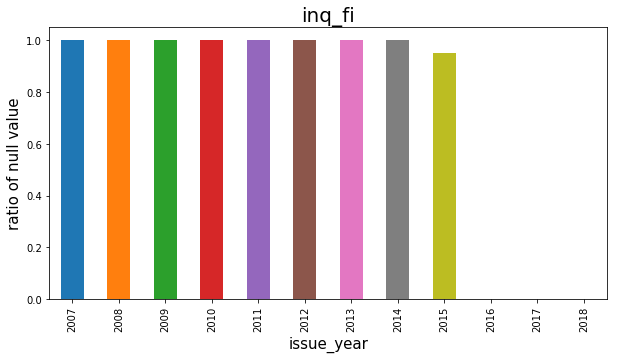

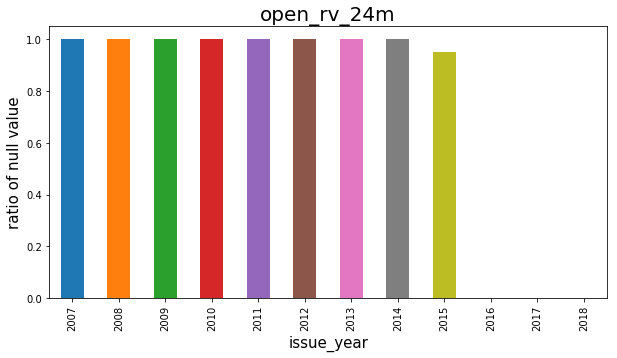

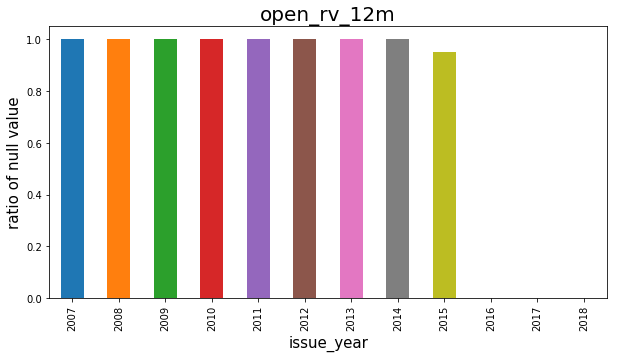

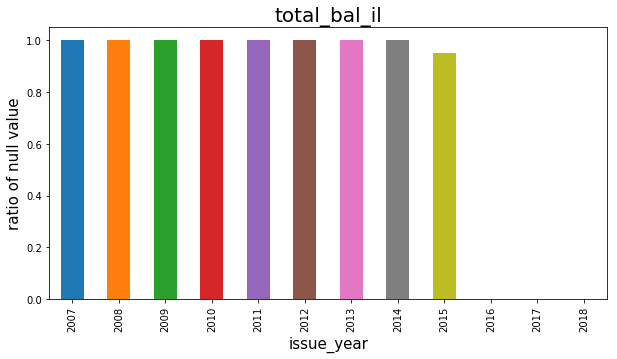

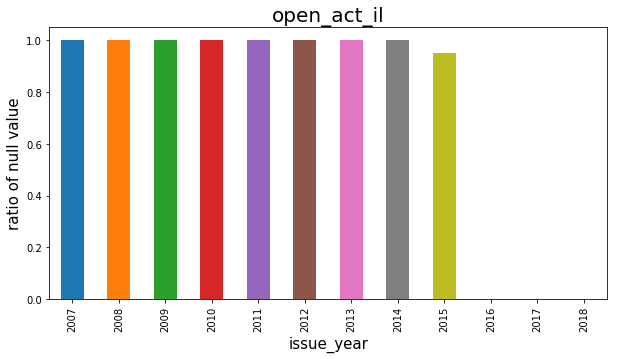

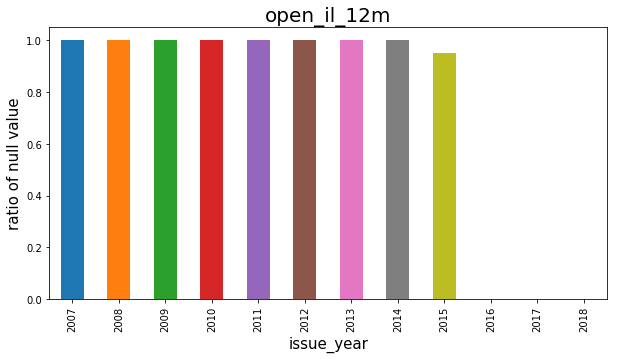

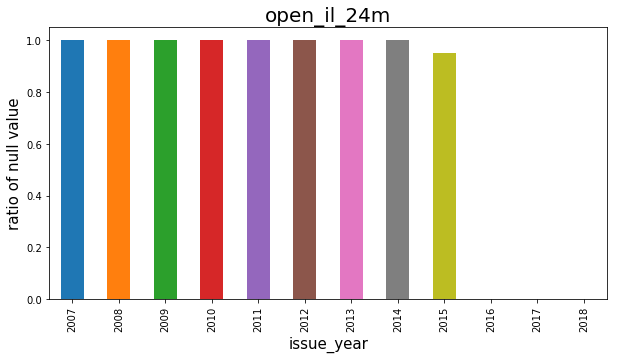

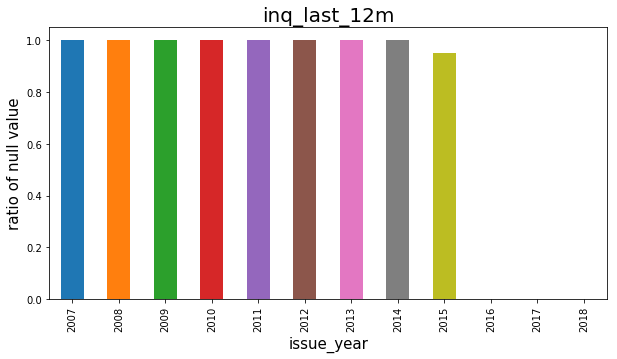

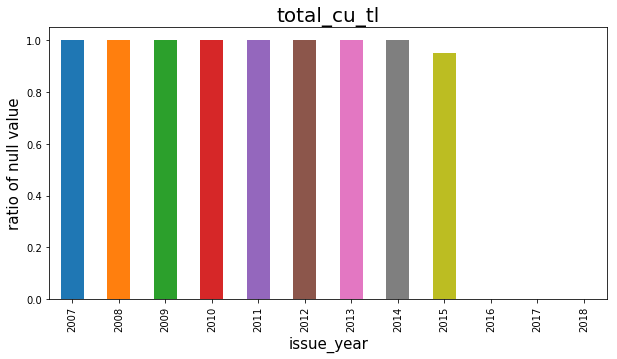

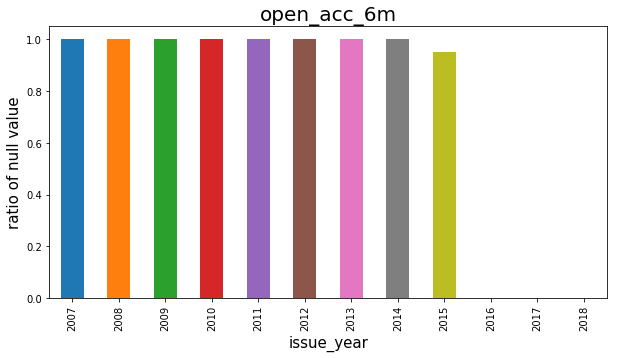

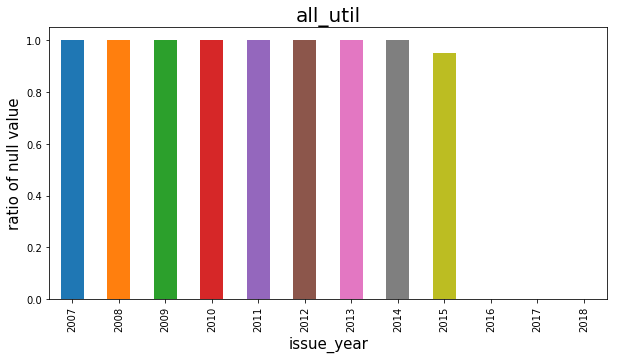

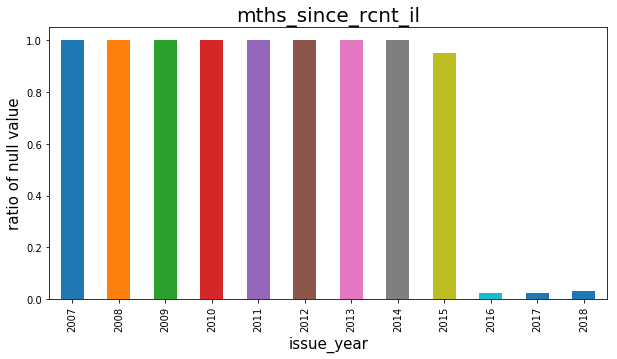

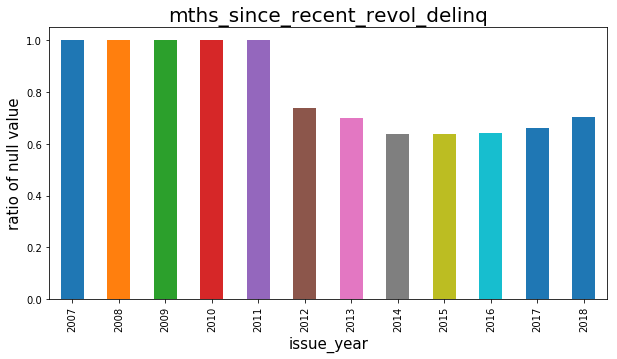

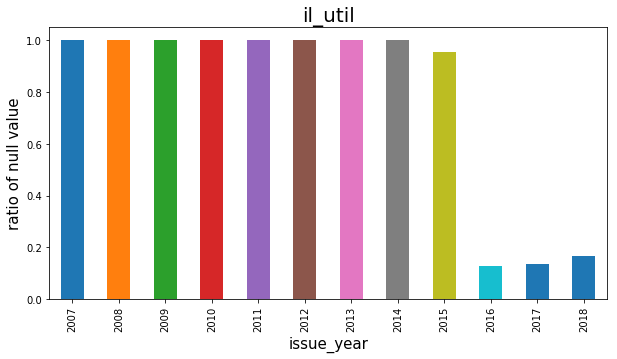

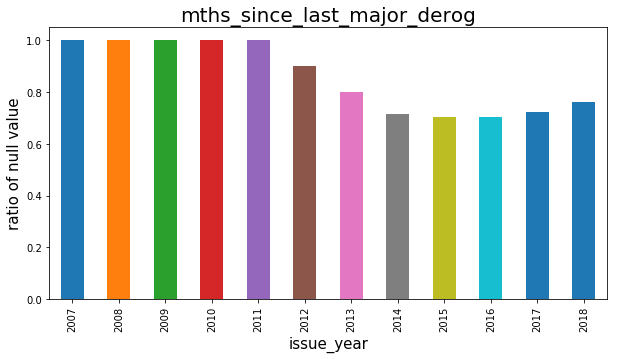

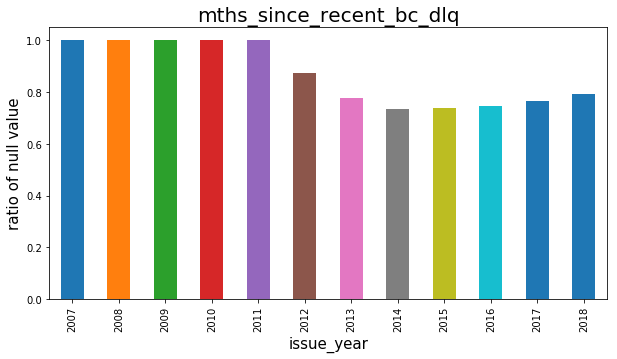

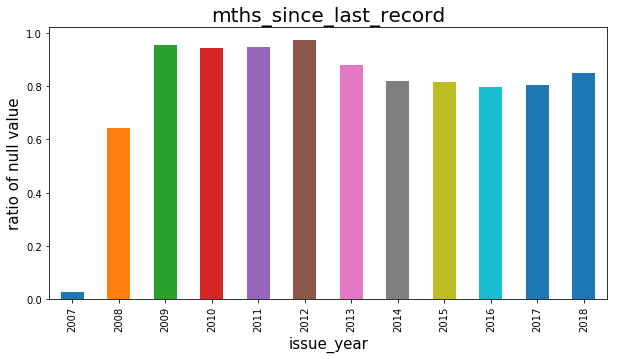

In [22]:
# Plot null ratio of features in list_non_joint across years
for feature in list_non_joint:
    plot_null(feature)

In [23]:
# for the following features, the null ratio is one by almost end of 2015 (more accurately by end of November 2015) 
# and 0 since 2016. 
# In other words, null values before 2016 mean the data is missing. Since this missing data is more than 60%, they are removed
# for now but they must be added to the model in a couple of years when more data will be available.

list_non_joint_removal = ['max_bal_bc','inq_fi','open_rv_24m','open_rv_12m','total_bal_il','open_act_il','open_il_12m',
                          'open_il_24m','inq_last_12m','total_cu_tl','open_acc_6m','all_util','mths_since_rcnt_il','il_util']

df.drop(list_non_joint_removal,axis=1,inplace=True)

In [24]:
# For two features, the ratio of null values varies across all years. Based on what the two features are representing, 
# it is concluded that null value is equvalent to zero. For example, 'mths_since_last_delinq' is the number of months since 
# borrower's last delinquency and null value means there is no delinquency.

list2 = ['mths_since_last_delinq','mths_since_last_record']
df.loc[:,list2] = df.loc[:,list2].fillna(0)

In [25]:
# for there features, null ratio is one by the end of 2011 and varies across the next years.
# In other words, null values before 2012 mean the data is missing, but null values since 2012 could have some meaning.
# Again, based on what the three features are representing, it is concluded null since values are equivalent to zero.

list3 = ['mths_since_recent_revol_delinq','mths_since_last_major_derog','mths_since_recent_bc_dlq']

# Add issue_year to df
df['issue_year']=df.issue_d.dt.year

# separate samples from 2011 and before
a = df.loc[df.issue_year<=2011,list3]

# Separate samples since 2012 and fill null values with 0
b = df.loc[df.issue_year>2011,list3]
b = b.fillna(0)

# Update dataframe
df.loc[:,list3] = pd.concat([a,b])

# Remove issue_year column
del df['issue_year']

In [26]:
# Chack the ratio of null values for the three features above
df.loc[:,list3].isnull().mean()

mths_since_recent_revol_delinq    0.031411
mths_since_last_major_derog       0.031411
mths_since_recent_bc_dlq          0.031411
dtype: float64

In [27]:
# Print categorical features
df.loc[:,df.dtypes[df.dtypes=='object'].index].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266618 entries, 0 to 1266617
Data columns (total 16 columns):
term                   1266618 non-null object
grade                  1266618 non-null object
sub_grade              1266618 non-null object
emp_title              1187023 non-null object
emp_length             1193901 non-null object
home_ownership         1266618 non-null object
verification_status    1266618 non-null object
pymnt_plan             1266618 non-null object
purpose                1266618 non-null object
title                  1252196 non-null object
zip_code               1266618 non-null object
addr_state             1266618 non-null object
earliest_cr_line       1266618 non-null object
initial_list_status    1266618 non-null object
application_type       1266618 non-null object
disbursement_method    1266618 non-null object
dtypes: object(16)
memory usage: 154.6+ MB


#### Some categorical features need to be converted to datetime format. For each categorical feature, two plots are shown; a pie plot which shows the percentage of each level of the feature, and a bar plot which shows the distribution of charged-off-to-all-loans ratio across the levels. The two plots provide some insight about the data. Also, if the distribution does not significantly change across different levels of a feature, it indicates the feature does not have a substantial impact on the loan status and could be removed.

In [32]:
# Define a function which creates the two pie and bar plots
def two_plots(feature,figure_size=(8,4),dataframe=df,label_rotation= 'horizontal'):
    """This function creates two plots for each categorical feature. The first one is a pie plot which shows the percentage of 
    each level of the feature across all samples. The second plot is a bar plot which shows the distribution of the 
    charged-off-to-total-loan ratio across all levels of the categorical feature."""
    # Pie plot
    dataframe[feature].value_counts().sort_index().plot.pie(autopct='%1.1f%%',startangle=0,figsize=figure_size,
                                                            textprops={'fontsize': 15})
    plt.axis('equal')
    plt.title('Pieplot of {}'.format(feature),fontsize=20,y=1.05)
    plt.ylabel('')
    #Bar plot
    plt.figure()
    (dataframe.groupby(feature)['charged_off'].mean().sort_values()).plot.bar(figsize = figure_size)
    plt.xlabel(feature,fontsize=20)
    plt.xticks(rotation=label_rotation,size=15)
    plt.ylabel('charged-off to total loan ratio',fontsize=20)
    plt.yticks(rotation=label_rotation,size=15)
    plt.title('Bar plot of {}'.format(feature),fontsize=20)
    plt.show()   

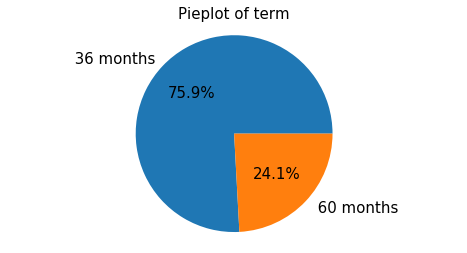

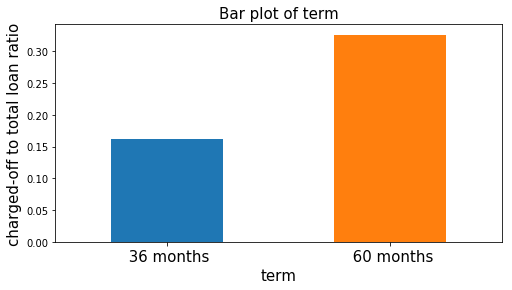

In [43]:
# Run tow_plots on term
two_plots('term')

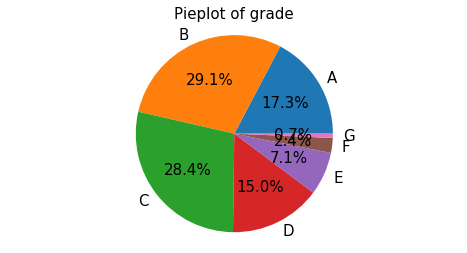

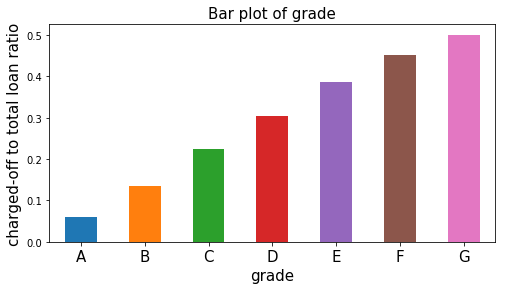

In [41]:
# Run two_plots on grade
two_plots('grade')

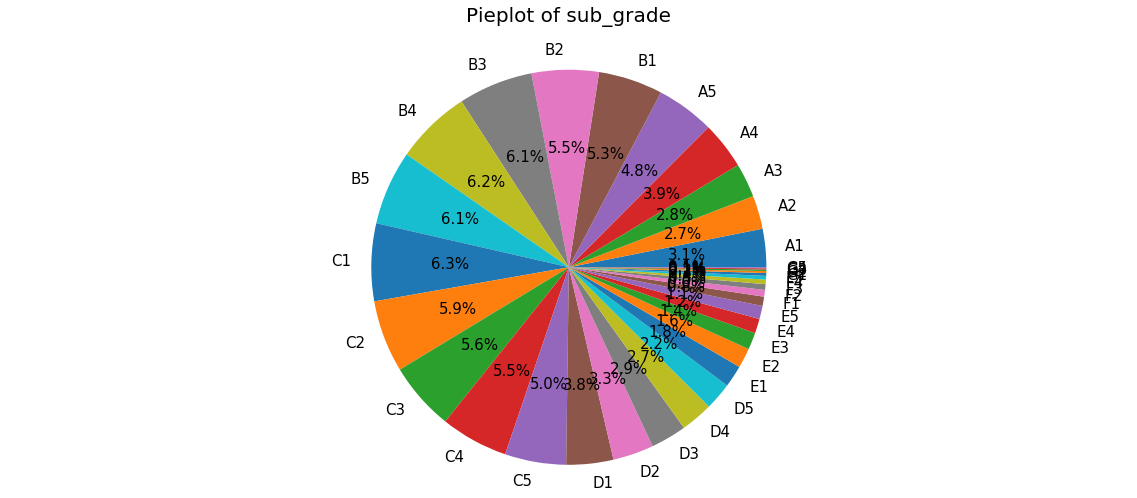

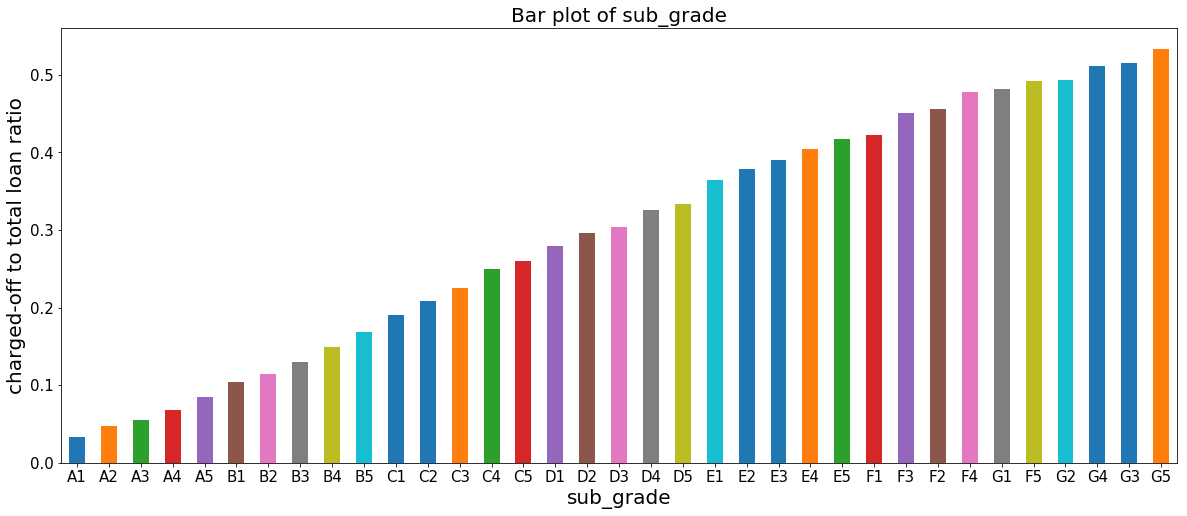

In [33]:
# Run two plots on sub_grade
two_plots('sub_grade',figure_size=(20,8))

#### The bar plot of sub grade shows the impact of sub-grades on charge-off-to-total-loan ratio across the grades are quite similar. Therefore, sub_grade can be removed from features

In [63]:
# Remove sub-grades from df
del df['sub_grade']

In [64]:
df.emp_title.nunique()

365272

#### There are two many unique values for employment title. Therefore, it is a high cardinality problem. The problem will be addressed later.

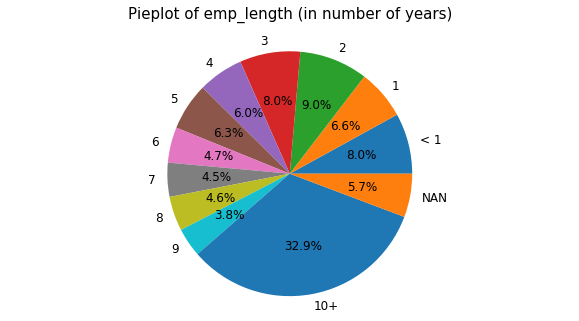

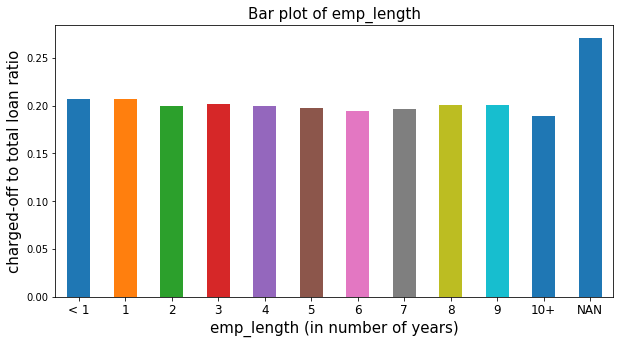

In [16]:
# emp_length has null values. Replace them with NaN
df.emp_length.replace(np.NAN,'NAN',inplace=True)

# Remove year(s) from the column
df.emp_length = df.emp_length.str.strip(' years').str.strip(' year')

# Rearrange the index
index = ['< 1','1', '2', '3', '4', '5','6', '7', '8', '9', '10+','NAN']

#Pie Plot
feature = 'emp_length'
figure_size=(10,5)
df[feature].value_counts()[index].plot.pie(autopct='%1.1f%%',startangle=0,figsize=figure_size,textprops={'fontsize': 12})
plt.axis('equal')
plt.title('Pieplot of {} (in number of years)'.format(feature),fontsize=15,y=1.05)
plt.ylabel('')
#Bar plot
plt.figure()
(df.groupby(feature)['charged_off'].mean()[index]).plot.bar(figsize = figure_size)
plt.xlabel('emp_length (in number of years)',fontsize=15)
plt.xticks(rotation='horizontal',size=12)
plt.ylabel('charged-off to total loan ratio',fontsize=15)
plt.title('Bar plot of {}'.format(feature),fontsize=15)
plt.show()   

#### Charged-off-to-total-loan ratio does not significantly change across different employment lengths. Also, the samples with null employment-length value have substantially higher charged-off-to-total-loan ratio than the samples with non-null values. It does not make sense to define NAN as a separate category because all possible employment lengths are covered in other categories. Therefore,  the feature is dropped.

In [65]:
# Drop emp_length
df.drop('emp_length',axis=1,inplace=True)

In [66]:
#Run value_counts on home ownership
df.home_ownership.value_counts()

MORTGAGE    627679
RENT        503075
OWN         135425
ANY            247
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

In [67]:
# Replace NONE and ANY labels with OTHER to simplify the feature 
df.home_ownership.replace(['ANY','NONE'],'OTHER',inplace=True)

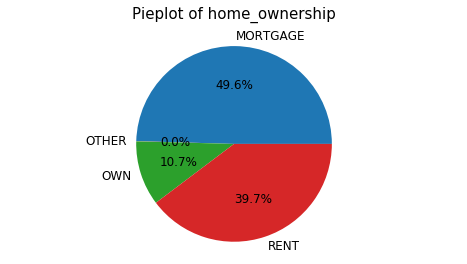

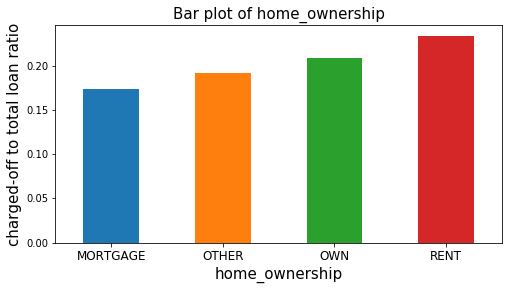

In [59]:
# Run tow_plots on home_ownership
two_plots('home_ownership')

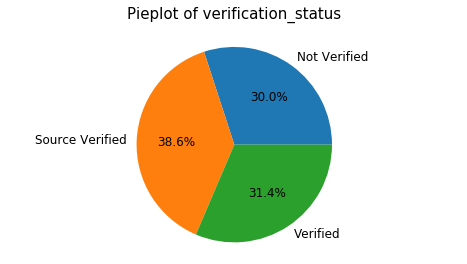

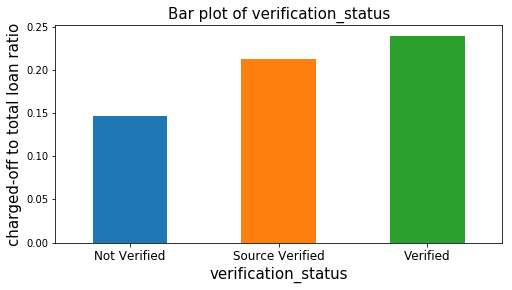

In [60]:
#Run two_plots on verification_status
two_plots('verification_status')

In [33]:
# Save the month of issue date in a new column
df['issue_month'] = df.issue_d.apply(lambda x:x.month).astype('int')

In [12]:
df['issue_month'].value_counts()

10    130422
7     124326
3     112456
11    108236
1     107577
8     107117
4     104344
5      99267
12     99187
6      95464
2      92144
9      86078
Name: issue_month, dtype: int64

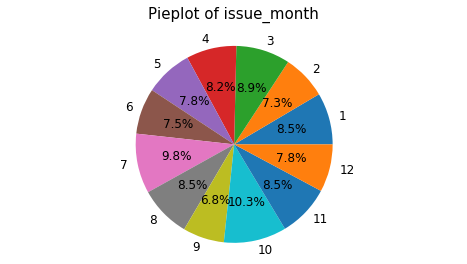

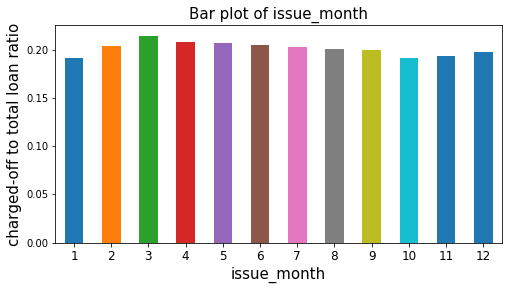

In [17]:
# Save the month of issue date in a new column
df['issue_month'] = df.issue_d.apply(lambda x:x.month)

# Rearrange the index
index = np.arange(1,13)

#Pie Plot
feature = 'issue_month'
figure_size=(8,4)
df[feature].value_counts()[index].plot.pie(autopct='%1.1f%%',startangle=0,figsize=figure_size,textprops={'fontsize': 12})
plt.axis('equal')
plt.title('Pieplot of {}'.format(feature),fontsize=15,y=1.05)
plt.ylabel('')
#Bar plot
plt.figure()
(df.groupby(feature)['charged_off'].mean()[index]).plot.bar(figsize = figure_size)
plt.xlabel('{}'.format(feature),fontsize=15)
plt.xticks(rotation='horizontal',size=12)
plt.ylabel('charged-off to total loan ratio',fontsize=15)
plt.title('Bar plot of {}'.format(feature),fontsize=15)
plt.show()   

#### There is no significant difference in charged-off-to-total-loan ratio between months. So issue_month can be removed

In [42]:
# Remove issue_month
df.drop('issue_month',axis=1,inplace=True)

In [68]:
# Run value counts on payment plan
df.pymnt_plan.value_counts()

n    1266618
Name: pymnt_plan, dtype: int64

In [69]:
# Remove payment plan because it has only one value
df.drop('pymnt_plan',axis=1,inplace=True)

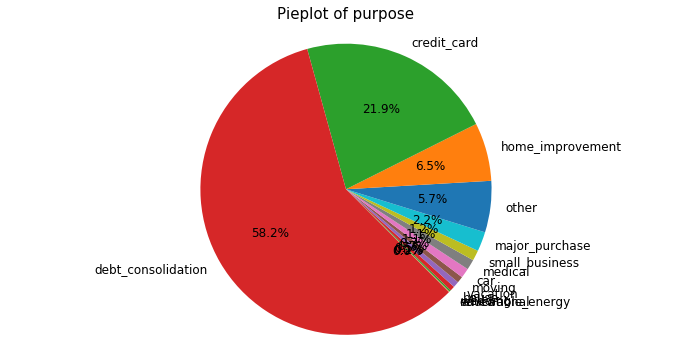

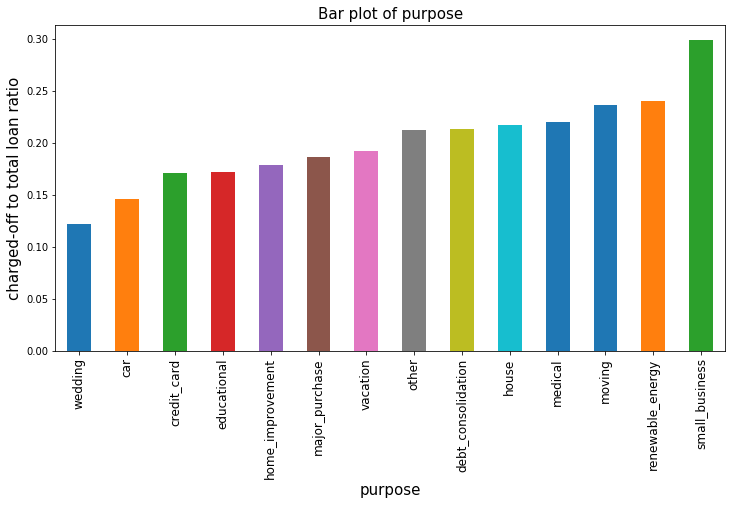

In [48]:
#Run two_plots on purpose
two_plots('purpose',figure_size=(12,6),label_rotation='vertical')

In [70]:
# Run value_counts on title
df.title.value_counts().head(20)

Debt consolidation           619241
Credit card refinancing      232590
Home improvement              69631
Other                         61279
Major purchase                22077
Debt Consolidation            15687
Medical expenses              12518
Business                      10978
Car financing                 10350
Vacation                       7459
Moving and relocation          7407
Consolidation                  5350
Home buying                    5340
debt consolidation             4808
Debt Consolidation Loan        3777
Credit Card Consolidation      2346
consolidation                  2163
Personal Loan                  2086
Consolidation Loan             1770
Home Improvement               1757
Name: title, dtype: int64

#### Elements of title are similar to elements of purpose. Therefore, purpose is enough and title is removed.

In [71]:
# Remove title from features
del df['title']

In [72]:
df.zip_code.nunique()

942

#### Zip code also has high cardinality problem and will be addressed later.

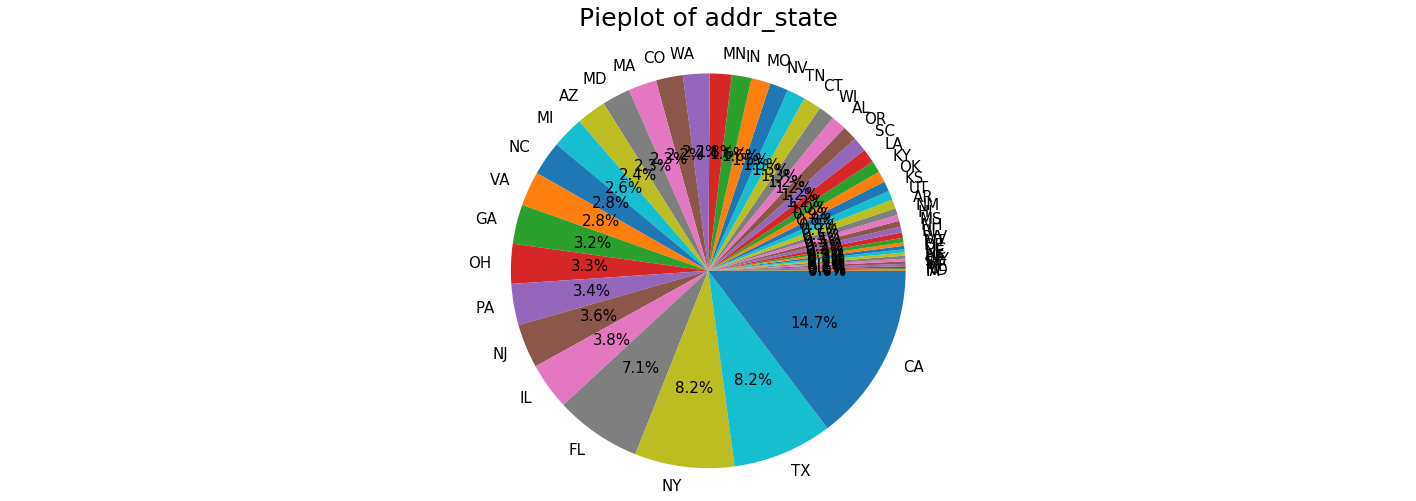

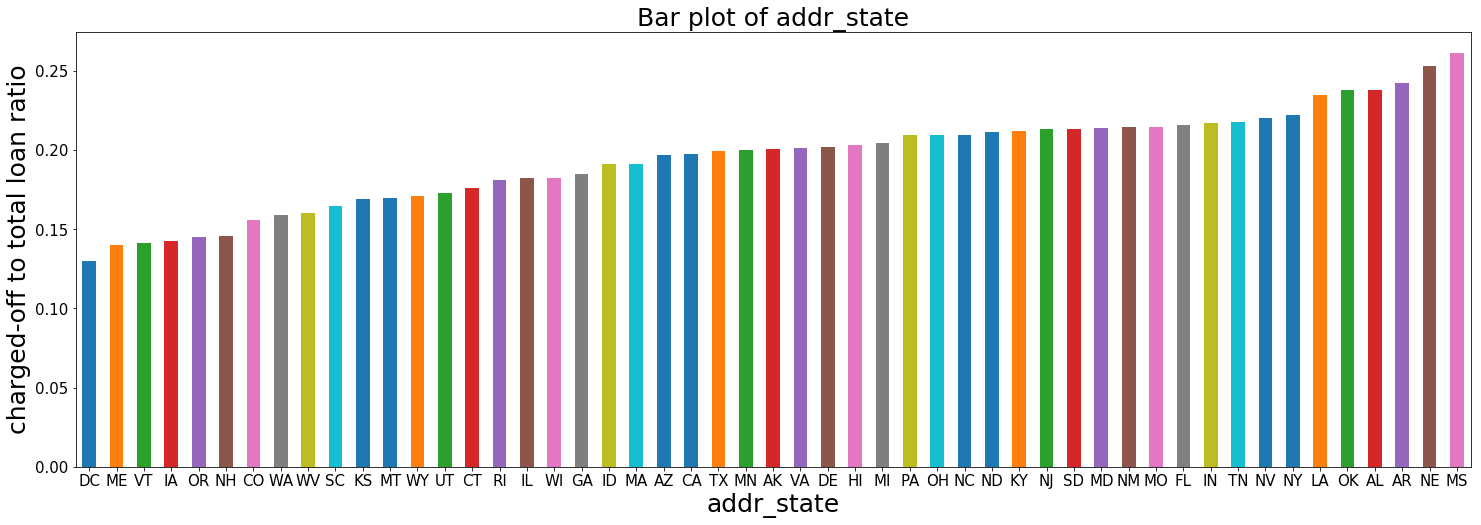

In [58]:
# Run two plots on address state
two_plots('addr_state',figure_size=(25,8))

In [73]:
# Transform earliest credit line to datetime format
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line,format='%b-%Y')

In [74]:
# Store number of years since the earliest credit line in a new column
df['years_earliest_cr_line'] = df.issue_d - df.earliest_cr_line
df['years_earliest_cr_line'] = df.years_earliest_cr_line.apply(lambda x:np.round(x.days/365,2))

In [75]:
# Drop earliest_cr_line
df.drop(['earliest_cr_line'],axis=1,inplace=True)

# Remove issue_d from df since it's no longer of use
df.drop('issue_d',axis=1,inplace=True)

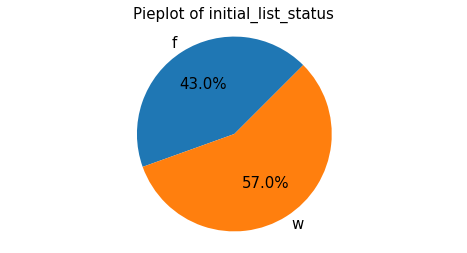

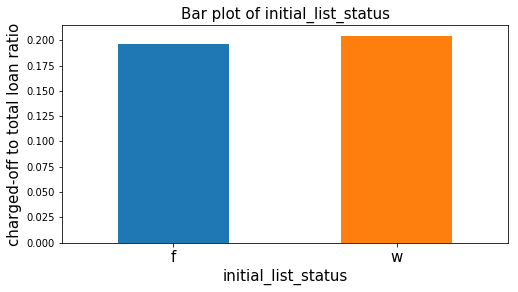

In [45]:
# Run two_plots on initial_list_status
two_plots('initial_list_status')

#### initial_list_status could be removed because it does not significantly impact loan status

In [76]:
# Remove initial_list_status 
df.drop('initial_list_status',axis=1,inplace=True)

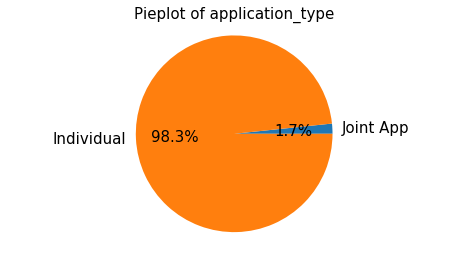

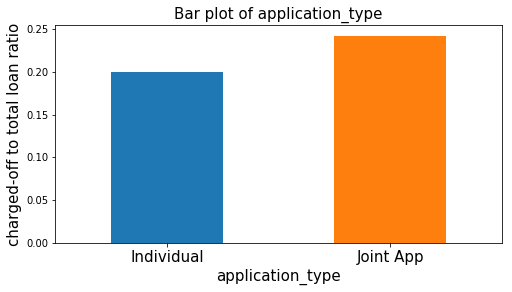

In [61]:
# Run two_plots on application_type
two_plots('application_type')

#### Although a small percentage of loans have joint applicants, they have a higher chance of becoming charged off.

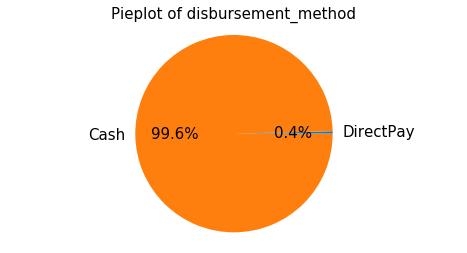

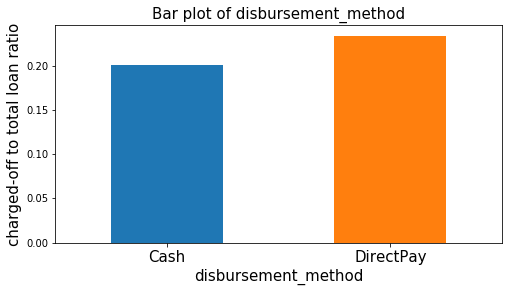

In [62]:
# Run disbursement_method on application_type
two_plots('disbursement_method')

In [80]:
# Print number of columns
len(df.columns)

74

In [58]:
# Save the wrangled data to a csv file
df.to_csv('df_wrangled.csv',index=False)